# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Preparation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('C:/Users/Kayo/Downloads/taxi.csv', parse_dates=[0])

In [3]:
# Checking Dataframe's general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [4]:
# Checking Dataframe's general info
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
# Checking Dataframe's general info
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
print('NaN Count:', df.isna().sum().sum())
print('Duplicate Rows:', len(df) - len(df.drop_duplicates()))

NaN Count: 0
Duplicate Rows: 0


The reason we didn't convert our index into datetime immediately like we did with parse_date is because if we checked for duplicates afterwards we would notice almost every row would be considered a duplicate, since a row with the same amount of orders appears as though a duplicate row if there's not an additional column to differentiate them.

In [7]:
df = df.set_index('datetime').resample('1H').sum()

## Analysis

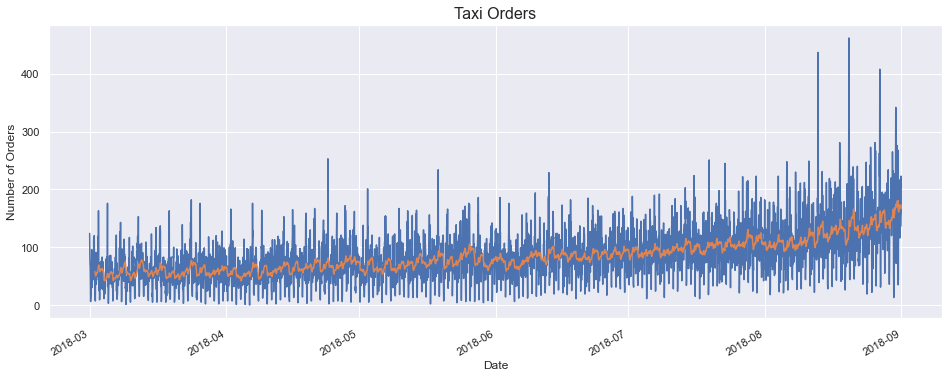

In [8]:
# Plotting our dataframe
sns.set(rc={'figure.figsize':(16, 6)})
sns.lineplot(data=df['num_orders']);
df['num_orders'].rolling(30).mean().plot();

plt.ylabel('Number of Orders');
plt.xlabel('Date');
plt.title('Taxi Orders', fontsize=16);

Our data seems fairly consistent in orders placed. Farther into the year there are more orders placed but it is overall stationary.

In [9]:
# Plotting trends in our data
df.sort_index(inplace=True)
decomposed = seasonal_decompose(df)

df_weeks = df['2018-06-01':'2018-06-3']
decomposed_twoweeks = seasonal_decompose(df_weeks)

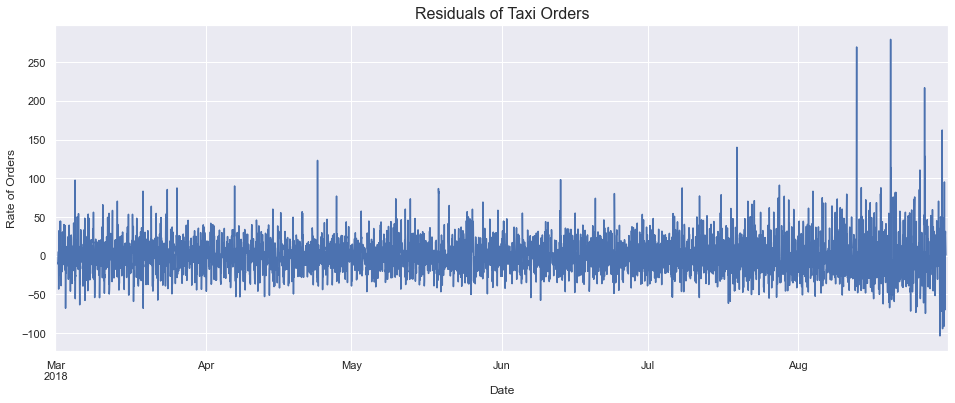

In [10]:
decomposed.resid.plot(ax=plt.gca());

plt.ylabel('Rate of Orders');
plt.xlabel('Date');
plt.title('Residuals of Taxi Orders', fontsize=16);

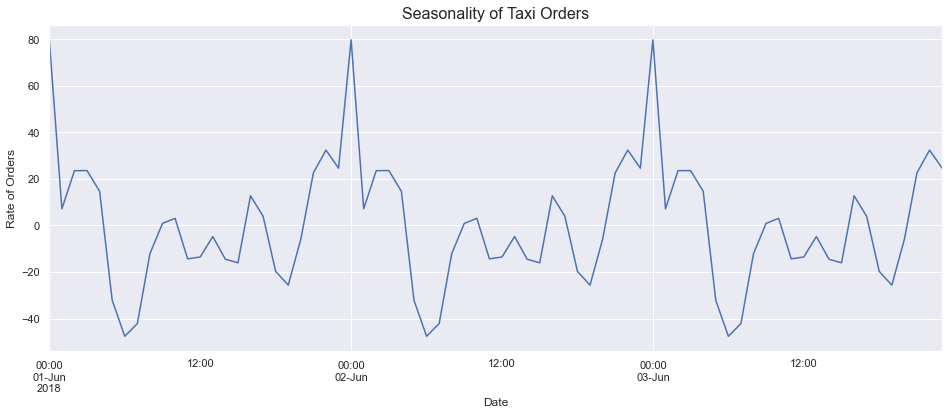

In [11]:
decomposed_twoweeks.seasonal.plot(ax=plt.gca());

plt.ylabel('Rate of Orders');
plt.xlabel('Date');
plt.title('Seasonality of Taxi Orders', fontsize=16);

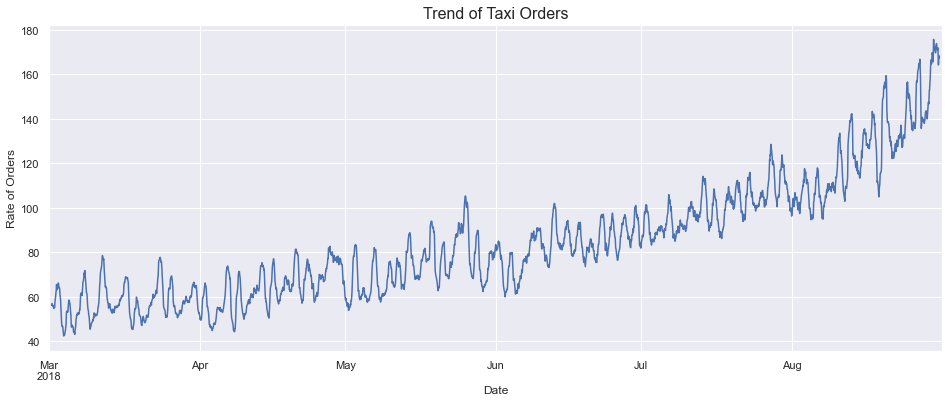

In [12]:
decomposed.trend.plot(ax=plt.gca());

plt.ylabel('Rate of Orders');
plt.xlabel('Date');
plt.title('Trend of Taxi Orders', fontsize=16);

The trend shows a higher rate of orders farther into August and beyond that, more than double.

The seasonal and residual plot are fairly consistent, and both are both very stationary. The seasonal graph shows the variations in orders per hours of the day, but oddly enough peaking around the hours of midnight and near those hours. There could be a correlation between the difficulty of finding a ride other than taxis around those hours, or an increase in how many people get off work around that time and would need taxis to get home. 

In fact, the seasonal graph is so consistent it could be a strong indicator of how the dataset may be fabricated (it's never too clear how real the datasets provided to us are) or that the rate of taxi orders is something fit into their customer's everyday schedule that doesn't change, further reinforcing the likelihood these orders are from people off work, school, and related daily activites.

## Training

In [13]:
# Creating features for our model
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 4, 10)
df = df.dropna()

In [14]:
# Creating model variables and checking their sizes for errors
target_train, target_test, features_train, features_test = train_test_split(
    df['num_orders'], df.drop(['num_orders'], axis=1), train_size=0.9, test_size=0.1)

print('Training set shapes:', features_train.shape, target_train.shape)
print('Testing set shapes:', features_test.shape, target_test.shape)

Training set shapes: (3965, 9) (3965,)
Testing set shapes: (441, 9) (441,)


### Linear Regression

In [15]:
# Testing Linear Regression with GridSearchCV for cross-validation
param_grid = {}

ccv = TimeSeriesSplit(n_splits=2)
LR = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid, cv=ccv)
LR.fit(features_train, target_train)

# Creating prediction variables
LR_predict_test = LR.predict(features_test)
print('RMSE of Linear Regression with Test set:', sqrt(mean_squared_error(target_test, LR_predict_test)))

RMSE of Linear Regression with Test set: 35.4594625582317


### Cat Boost

In [16]:
# Tuning Cat Boost Regressors parameters using GridSearchCV
# due to hardware limitations there are limited models being trained here and for Random Forest
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)],
    'max_depth': [int(x) for x in np.linspace(3, 15, num = 3)],
}

ccv = TimeSeriesSplit(n_splits=2)
CB_rfc = GridSearchCV(estimator=CatBoostRegressor(random_state=123, logging_level='Silent'), param_grid=param_grid, cv=ccv)
CB_rfc.fit(features_train, target_train)

# Creating prediction variables
CB_predict_test = CB_rfc.predict(features_test)
print('RMSE of Cat Boost Regression with Test set:', sqrt(mean_squared_error(target_test, CB_predict_test)))

RMSE of Cat Boost Regression with Test set: 33.62406030083145


### Random Forest

In [17]:
# Tuning Random Forest Regressors parameters using GridSearchCV
param_grid = {
    'n_estimators': [100, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [3, 15],
}

ccv = TimeSeriesSplit(n_splits=2)
RFR_rfc = GridSearchCV(estimator=RandomForestRegressor(random_state=123), param_grid=param_grid, cv=ccv)
RFR_rfc.fit(features_train, target_train)

# Creating prediction variables
RFR_predict_test = RFR_rfc.predict(features_test)
print('RMSE of Cat Boost Regression with Test set:', sqrt(mean_squared_error(target_test, RFR_predict_test)))

RMSE of Cat Boost Regression with Test set: 33.185912144305576


## Testing

In [18]:
print('Final RMSE of Linear Regression:', sqrt(mean_squared_error(target_test, LR_predict_test)))
print('Final RMSE of Cat Boost Regression:', sqrt(mean_squared_error(target_test, CB_predict_test)))
print('Final RMSE of Random Forest Regression:', sqrt(mean_squared_error(target_test, RFR_predict_test)))

Final RMSE of Linear Regression: 35.4594625582317
Final RMSE of Cat Boost Regression: 33.62406030083145
Final RMSE of Random Forest Regression: 33.185912144305576


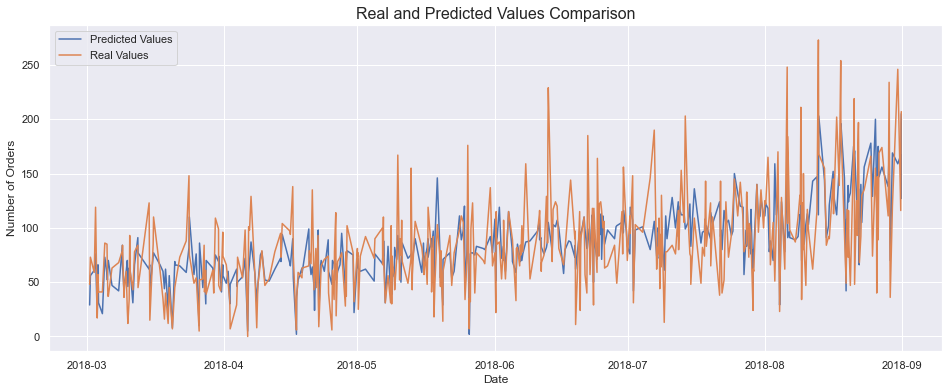

In [19]:
## Comparing real and predicted values of our best model
# Predicted Values - CatBoost
target_test = pd.DataFrame(target_test)
sns.lineplot(x=target_test.index,
             y=np.squeeze(CB_predict_test.astype(np.int64)));
# True Values
sns.lineplot(x=target_test.index,
             y=target_test['num_orders']);

plt.ylabel('Number of Orders');
plt.xlabel('Date');
plt.title('Real and Predicted Values Comparison', fontsize=16);
plt.legend(labels=['Predicted Values', 'Real Values']);

We were able to create features using the date and we noticed a higher rate of orders past August, which can strongly suggest a Winter trend in orders, but could be coincidence or indicate something else given the dataset only goes as far as one year. We would need a longer range of dates to ensure this is consistent.

Our RMSE is lower than 48, our goal for this metric. The best RMSE we were able to aquire seems to be CatBoost, having an RMSE of 33.